# Predictive Restaurant Recommender

This project builds a **predictive recommendation engine** that suggests which restaurants (vendors) a customer is most likely to order from, based on:

- Customer location and order history  
- Vendor information and popularity trends  
- Historical customer-vendor interaction patterns  


## Project Objectives

- Predict vendor(s) a customer will order from for a given saved location.  
- Avoid data leakage and produce realistic validation.  
- Output results in required `CID X LOC_NUM X VENDOR target` format.


## Project Pipeline

The full pipeline consists of the following stages:

1. **Data Loading & Preprocessing:** Read and clean raw datasets, merge relevant tables, and generate candidate `(customer, location, vendor)` pairs.  
2. **Exploratory Data Analysis (EDA):** Understand order behavior, customer frequency, and vendor distribution patterns.  
3. **Feature Engineering:** Enrich data with behavioral and popularity-based features (e.g., vendor popularity, customer activity, recency scores).  
4. **Model Training (LightGBM):** Train a predictive model to estimate the probability of future orders.  
5. **Ranking & Recommendation:** Rank vendors for each customer-location pair and assign `1` to the top-K most likely choices.  
6. **Evaluation & Submission:** Evaluate using ranking metrics (Precision@K, MAP@K) and generate the final submission file in the required format.


## Tech Stack

- Python (pandas, numpy, scikit-learn) - data processing and modeling.  
- LightGBM - gradient-boosted model for binary classification / ranking.  
- CSV files - dataset format (train/test).


## Libraries Used

- **pandas** - read/clean/merge CSVs.  
- **numpy** - numeric ops, sampling and arrays.  
- **scikit-learn** (GroupKFold, f1_score) - grouped CV and evaluation.  
- **lightgbm** - fast tree boosting model.  
- **tqdm** - progress bars for loops (negative sampling).  
- **zipfile / os** - file extraction and path handling.


## Step 1 - Install & unzip

Install required packages and extract `train and test data.zip` into the Colab workspace so CSVs are available for the pipeline.


In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, precision_recall_fscore_support
import lightgbm as lgb


In [2]:
zip_path = "/content/train and test data.zip"
if os.path.exists(zip_path):
    print("Found zip; extracting...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall("/content/extracted_data")
    base_train = "/content/extracted_data/train and test data/Train"
    base_test = "/content/extracted_data/train and test data/Test"
else:
    # CSVs already placed in /content or working dir, adjusted paths below
    base_train = "/content/Train"
    base_test = "/content/Test"

Found zip; extracting...


## Step 2 - Load CSV files

Read train/test CSV files into pandas DataFrames (`orders`, `vendors`, `train/test_customers`, `train/test_locations`).


In [3]:
#Load CSV files
def load_csv(path):
    print("Loading", path)
    return pd.read_csv(path)

In [4]:
#Read all CSV files
orders = load_csv(os.path.join(base_train, "orders.csv"))
train_customers = load_csv(os.path.join(base_train, "train_customers.csv"))
train_locations = load_csv(os.path.join(base_train, "train_locations.csv"))
vendors = load_csv(os.path.join(base_train, "vendors.csv"))

test_customers = load_csv(os.path.join(base_test, "test_customers.csv"))
test_locations = load_csv(os.path.join(base_test, "test_locations.csv"))

Loading /content/extracted_data/train and test data/Train/orders.csv


/tmp/ipython-input-2066268545.py:4: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


Loading /content/extracted_data/train and test data/Train/train_customers.csv
Loading /content/extracted_data/train and test data/Train/train_locations.csv
Loading /content/extracted_data/train and test data/Train/vendors.csv
Loading /content/extracted_data/train and test data/Test/test_customers.csv
Loading /content/extracted_data/train and test data/Test/test_locations.csv


## Step 3 - Exploratory Data Analysis (Before Cleaning)

Perform an initial EDA to understand raw data distribution, missing values, class imbalance, and anomalies. This informs cleaning choices and feature ideas.


In [5]:
# Inspect Dataset Shapes
print("\nShapes:")
print("orders:", orders.shape)
print("train_customers:", train_customers.shape)
print("train_locations:", train_locations.shape)
print("vendors:", vendors.shape)
print("test_customers:", test_customers.shape)
print("test_locations:", test_locations.shape)


Shapes:
orders: (135303, 26)
train_customers: (34674, 8)
train_locations: (59503, 5)
vendors: (100, 59)
test_customers: (9768, 8)
test_locations: (16720, 5)


Orders columns: ['order_id', 'customer_id', 'item_count', 'grand_total', 'payment_mode', 'promo_code', 'vendor_discount_amount', 'promo_code_discount_percentage', 'is_favorite', 'is_rated', 'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime', 'delivery_time', 'order_accepted_time', 'driver_accepted_time', 'ready_for_pickup_time', 'picked_up_time', 'delivered_time', 'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER', 'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR']
Orders shape: (135303, 26)

Top 10 missing columns in orders:
promo_code                        130998
delivery_time                     130180
delivery_date                      99759
vendor_rating                      90083
driver_accepted_time               88845
promo_code_discount_percentage     69423
preparationtime                    55560
picked_up_time                     51438
ready_for_pickup_time              51054
delivered_time                     49562
LOCATION_TYPE                     

,order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163923.0,KL09J9N,6.0,10.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,84,8/2/2024 5:33,0,Work,KL09J9N X 0 X 84
1,163924.0,H5LGGFX,3.0,8.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,78,8/2/2024 5:34,0,Home,H5LGGFX X 0 X 78
2,163925.0,CYLZB6T,4.0,15.0,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,4,8/2/2024 5:35,0,Work,CYLZB6T X 0 X 4


,count
object,14
float64,8
int64,4



Top 20 vendors by order count (raw):


,count
vendor_id,
113,7807
105,5562
79,5117
84,5001
78,4643
83,3684
386,3280
86,2837
846,2559



Orders per customer - summary:
count    27445.000000
mean         4.929969
std          7.621525
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        262.000000
Name: count, dtype: float64


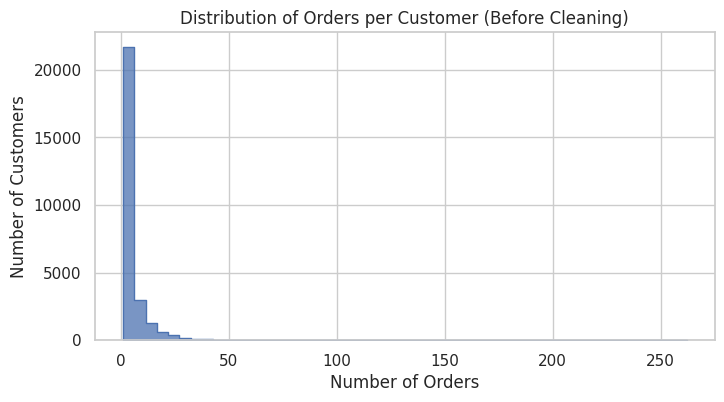

/tmp/ipython-input-3038421052.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vendors_raw.values, y=top_vendors_raw.index, palette='viridis')


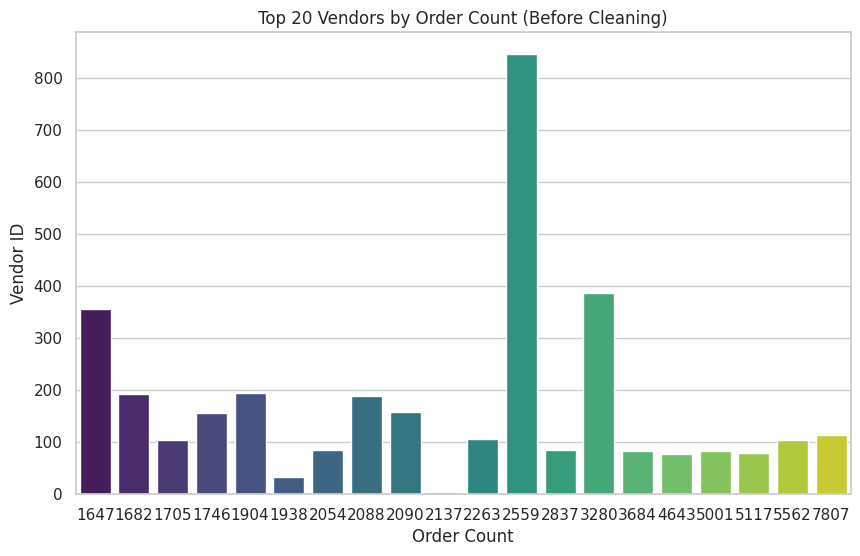

/tmp/ipython-input-3038421052.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_loc.values, y=orders_loc.index, palette='crest')


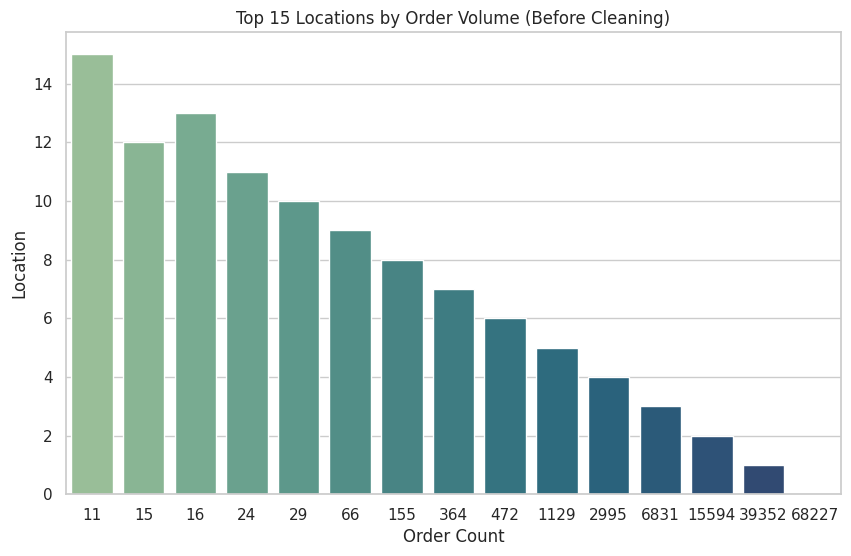

In [6]:
# EDA BEFORE CLEANING
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

# Basic overview
print("Orders columns:", orders.columns.tolist())
print("Orders shape:", orders.shape)
print("\nTop 10 missing columns in orders:")
print(orders.isnull().sum().sort_values(ascending=False).head(20))

# Basic stats
print("\nOrders - head and dtypes:")
display(orders.head(3))
display(orders.dtypes.value_counts())

# Top vendors
top_vendors_raw = orders['vendor_id'].value_counts().head(20)
print("\nTop 20 vendors by order count (raw):")
display(top_vendors_raw)

# Orders per customer
orders_per_customer = orders['customer_id'].value_counts()
print("\nOrders per customer - summary:")
print(orders_per_customer.describe())

# Visualizations: Before cleaning
plt.figure(figsize=(8,4))
sns.histplot(orders_per_customer, bins=50, element='step')
plt.title("Distribution of Orders per Customer (Before Cleaning)")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=top_vendors_raw.values, y=top_vendors_raw.index, palette='viridis')
plt.title("Top 20 Vendors by Order Count (Before Cleaning)")
plt.xlabel("Order Count")
plt.ylabel("Vendor ID")
plt.show()

# Orders per location (top 15)
if 'LOCATION_NUMBER' in orders.columns:
    orders_loc = orders['LOCATION_NUMBER'].value_counts().head(15)
elif 'loc_num' in orders.columns:
    orders_loc = orders['loc_num'].value_counts().head(15)
else:
    # look for any column resembling location
    loc_cols = [c for c in orders.columns if 'loc' in c.lower() or 'location' in c.lower()]
    orders_loc = orders[loc_cols[0]].value_counts().head(15) if loc_cols else pd.Series()
if not orders_loc.empty:
    plt.figure(figsize=(10,6))
    sns.barplot(x=orders_loc.values, y=orders_loc.index, palette='crest')
    plt.title("Top 15 Locations by Order Volume (Before Cleaning)")
    plt.xlabel("Order Count")
    plt.ylabel("Location")
    plt.show()


### EDA - Interpretation (Before Cleaning)

- **Orders per customer**: The histogram shows most customers have few orders (long-tail behavior).  
- **Top vendors**: A small number of vendors capture a large share of orders - high popularity skew.  
- **Top locations**: Shows where order volume concentrates.  

These patterns indicate sparsity and popularity bias, which will inform features like vendor popularity and customer recency.


## Step 4 - Data Cleaning & Preprocessing

We remove target columns, normalize column names and types, handle duplicates, and standardize id types to strings for safe merges and encodings.

**Critical:** Remove any precomputed submission-like column (e.g. `CID X LOC_NUM X VENDOR`) from training data so the model cannot trivially learn the answer.


In [7]:
# Drop target columns if present
target_cols = ['CID X LOC_NUM X VENDOR', 'CID X LOC_NUM X VENDOR ']
for c in target_cols:
    if c in orders.columns:
        orders.drop(columns=[c], inplace=True)
        print("Dropped", c, "from orders")

# Drop from other frames just in case
for df in [train_customers, train_locations, vendors, test_customers, test_locations]:
    for c in target_cols:
        if c in df.columns:
            df.drop(columns=[c], inplace=True)
            print("Dropped", c, "from a dataframe")
print("Done dropping target columns.")

Dropped CID X LOC_NUM X VENDOR from orders
Done dropping target columns.


## Normalize names & types

Standardize column names (e.g. `LOCATION_NUMBER` → `loc_num`), and convert IDs (`customer_id`, `vendor_id`, `loc_num`) to strings to ensure safe merging and consistent encoding.


In [8]:
# Normalize common column names (to adjust if different)
if 'LOCATION_NUMBER' in orders.columns:
    orders.rename(columns={'LOCATION_NUMBER': 'loc_num'}, inplace=True)
if 'LOCATION_TYPE' in orders.columns:
    orders.rename(columns={'LOCATION_TYPE': 'loc_type'}, inplace=True)
if 'location_number' in test_locations.columns:
    test_locations.rename(columns={'location_number': 'loc_num'}, inplace=True)
if 'location_number' in train_locations.columns:
    train_locations.rename(columns={'location_number': 'loc_num'}, inplace=True)
if 'id' in vendors.columns and 'vendor_id' not in vendors.columns:
    vendors.rename(columns={'id': 'vendor_id'}, inplace=True)

# Ensure key columns are strings
for df in [orders, test_locations, train_locations, test_customers, train_customers]:
    for c in ['customer_id', 'loc_num']:
        if c in df.columns:
            df[c] = df[c].astype(str)

if 'vendor_id' in orders.columns:
    orders['vendor_id'] = orders['vendor_id'].astype(str)
if 'vendor_id' in vendors.columns:
    vendors['vendor_id'] = vendors['vendor_id'].astype(str)

print("Normalized columns and types.")

Normalized columns and types.


## Step 5 - Exploaratory Data Analysis (After Cleaning)

We re-check distributions and missingness after cleaning to ensure no important signals were removed and data consistency improved.


Missing values after cleaning (orders):


,0
promo_code,130998
delivery_time,130180
delivery_date,99759
vendor_rating,90083
driver_accepted_time,88845
promo_code_discount_percentage,69423
preparationtime,55560
picked_up_time,51438
ready_for_pickup_time,51054
delivered_time,49562



Top 20 vendors (after cleaning):


,count
vendor_id,
113,7807
105,5562
79,5117
84,5001
78,4643
83,3684
386,3280
86,2837
846,2559


/tmp/ipython-input-623233257.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vendors.values, y=top_vendors.index, palette='magma')


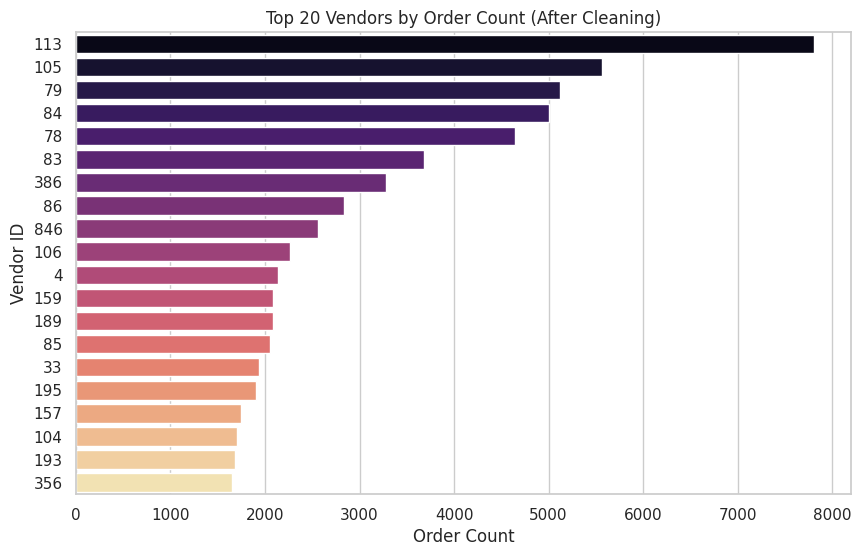

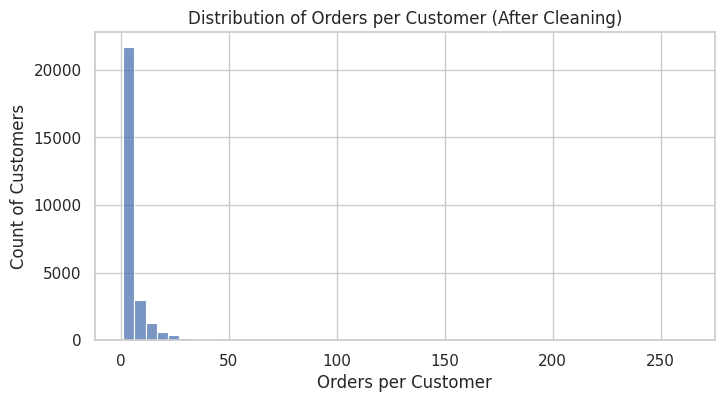

/tmp/ipython-input-623233257.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_loc_clean.values, y=orders_loc_clean.index, palette='rocket')


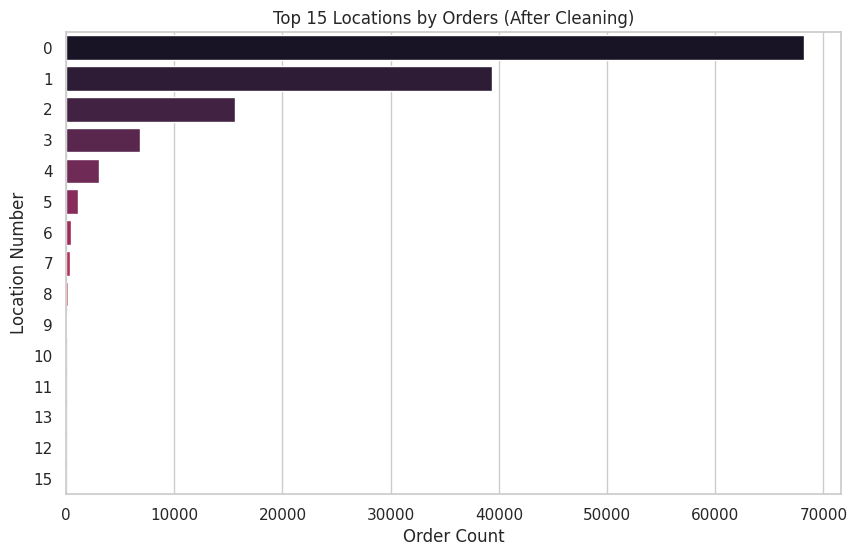

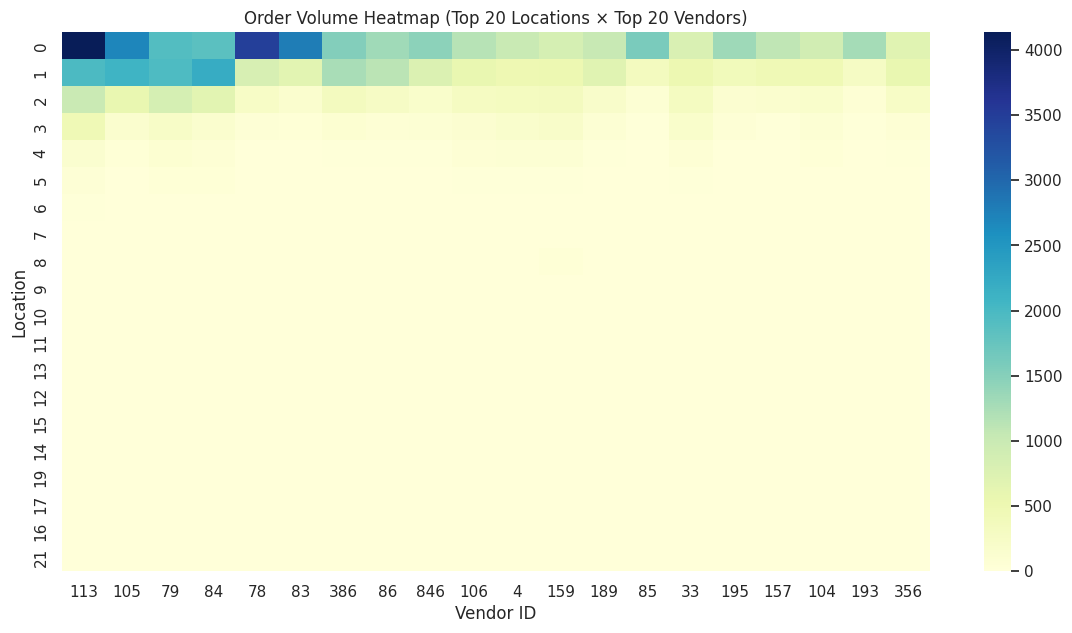

In [9]:
# EDA AFTER cleaning
print("Missing values after cleaning (orders):")
display(orders.isnull().sum().sort_values(ascending=False).head(20))

# Top vendors after cleaning
top_vendors = orders['vendor_id'].value_counts().head(20)
print("\nTop 20 vendors (after cleaning):")
display(top_vendors)

# Visualize vendor popularity after cleaning
plt.figure(figsize=(10,6))
sns.barplot(x=top_vendors.values, y=top_vendors.index, palette='magma')
plt.title("Top 20 Vendors by Order Count (After Cleaning)")
plt.xlabel("Order Count")
plt.ylabel("Vendor ID")
plt.show()

# Orders per customer after cleaning
orders_per_customer_clean = orders['customer_id'].value_counts()
plt.figure(figsize=(8,4))
sns.histplot(orders_per_customer_clean, bins=50)
plt.title("Distribution of Orders per Customer (After Cleaning)")
plt.xlabel("Orders per Customer")
plt.ylabel("Count of Customers")
plt.show()

# Orders per location after cleaning (top 15)
if 'loc_num' in orders.columns:
    orders_loc_clean = orders['loc_num'].value_counts().head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(x=orders_loc_clean.values, y=orders_loc_clean.index, palette='rocket')
    plt.title("Top 15 Locations by Orders (After Cleaning)")
    plt.xlabel("Order Count")
    plt.ylabel("Location Number")
    plt.show()

#  Heatmap: Vendor vs Location order volume (After Cleaning)

if 'vendor_id' in orders.columns and ('LOCATION_NUMBER' in orders.columns or 'loc_num' in orders.columns):
    loc_col = 'LOCATION_NUMBER' if 'LOCATION_NUMBER' in orders.columns else 'loc_num'
    heatmap_data = orders.groupby([loc_col, 'vendor_id']).size().unstack(fill_value=0)

    # Optional: only show top 20x20 for readability
    top_locs = heatmap_data.sum(axis=1).sort_values(ascending=False).head(20).index
    top_vendors = heatmap_data.sum(axis=0).sort_values(ascending=False).head(20).index
    heatmap_sub = heatmap_data.loc[top_locs, top_vendors]

    plt.figure(figsize=(14,7))
    sns.heatmap(heatmap_sub, cmap="YlGnBu")
    plt.title("Order Volume Heatmap (Top 20 Locations × Top 20 Vendors)")
    plt.xlabel("Vendor ID")
    plt.ylabel("Location")
    plt.show()


### EDA — Interpretation & Key Observations (After Cleaning)

- **Missingness:** We verified there are few critical missing values in key columns; these will be handled during feature engineering.  
- **Vendor popularity:** The popularity skew remains, confirming the need for vendor popularity features and class balancing.  
- **Customer activity distribution:** Still long-tailed; consider per-customer features (distinct vendors, recency).  
- **Conclusion:** Cleaning preserved core distributional patterns; proceed to feature engineering and negative sampling.


## Step 6 - Positive pairs

Create unique positive examples from historical orders: one row per `(customer_id, loc_num, vendor_id)` with `label=1`.


In [10]:
# Positive pairs (unique historical triples)
pos_pairs = orders[['customer_id','loc_num','vendor_id']].drop_duplicates().copy()
pos_pairs['label'] = 1
print("Positive pairs:", pos_pairs.shape)
display(pos_pairs.head())

Positive pairs: (80142, 4)


,customer_id,loc_num,vendor_id,label
0,KL09J9N,0,84,1
1,H5LGGFX,0,78,1
2,CYLZB6T,0,4,1
3,4YKUKYN,0,157,1
4,WDNU30K,0,160,1


## Step 7 - Negative sampling

For each positive pair, sample N different vendors (not the true vendor) to create negative examples (`label=0`). This produces balanced training data without building a huge cartesian product.


In [11]:
# Negative sampling
import numpy as np
from tqdm import tqdm

n_neg = 5
all_vendors = vendors['vendor_id'].unique().astype(str)
np.random.seed(42)

neg_rows = []
print("Sampling negatives for each positive (this may take a while)...")
for _, row in tqdm(pos_pairs.iterrows(), total=len(pos_pairs)):
    cid, loc, true_v = row['customer_id'], row['loc_num'], row['vendor_id']
    chosen = set()
    while len(chosen) < n_neg:
        cand = np.random.choice(all_vendors)
        if cand != true_v:
            chosen.add(cand)
    for v in chosen:
        neg_rows.append((cid, loc, v, 0))

neg_df = pd.DataFrame(neg_rows, columns=['customer_id','loc_num','vendor_id','label'])
print("Negatives shape:", neg_df.shape)

Sampling negatives for each positive (this may take a while)...


100%|██████████| 80142/80142 [00:13<00:00, 6061.31it/s]


Negatives shape: (400710, 4)


## Step 8 - Combine & shuffle

Concatenate positive and negative pairs, shuffle the resulting training set, and inspect label balance before training.


In [12]:
# Combine and shuffle
train_pairs = pd.concat([pos_pairs, neg_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined train pairs:", train_pairs.shape)
display(train_pairs.head())
print("Label distribution:")
print(train_pairs['label'].value_counts(normalize=True))

Combined train pairs: (480852, 4)


,customer_id,loc_num,vendor_id,label
0,4Q7OSJA,3,67,1
1,9YYDXJD,0,148,1
2,UOXLYXB,5,196,0
3,7D7GG9F,0,28,0
4,6COBF8M,1,149,0


Label distribution:
label
0    0.833333
1    0.166667
Name: proportion, dtype: float64


## Step 9 - Feature Engineering

In this step, we enrich our training data with several **powerful aggregate features** computed from historical order data. These features capture user preferences, vendor popularity, and ordering patterns - all of which help the model make more accurate predictions.

We engineer the following four key features:

1. **Vendor Popularity per Location** - Total number of orders a vendor has received within a specific location. This helps the model understand which vendors are generally popular among customers in the same area.  
2. **Customer-Vendor Interaction History** - A binary indicator showing whether a customer has previously ordered from a particular vendor. Repeat purchases are highly predictive of future orders.  
3. **Customer Activity Level** - The total number of orders placed by a customer overall. Highly active customers tend to explore more vendors, while less active ones show stronger brand loyalty.  
4. **Vendor Recency Score** - A time-decay weighted popularity score, where recent orders contribute more than older ones. This feature helps the model capture current trends and recently popular vendors.

All of these features are calculated **only from the training period** to avoid data leakage and are then merged into both the training and test candidate pairs. Together, they provide richer behavioral and popularity signals to significantly improve recommendation quality.



In [13]:
# 1) Vendor popularity by location  (FEATURE ENGINEERING - NEW)
#    counts how many historical orders each vendor had in each LOCATION (loc_num)
vendor_loc_pop = orders.groupby(['loc_num','vendor_id']).size().reset_index(name='vendor_loc_orders')
train_pairs = train_pairs.merge(vendor_loc_pop, on=['loc_num','vendor_id'], how='left')
train_pairs['vendor_loc_orders'] = train_pairs['vendor_loc_orders'].fillna(0)

In [14]:
# 2) Customer has ordered from vendor before (binary)  (FEATURE ENGINEERING - NEW)
cust_vendor_hist = orders.groupby(['customer_id','vendor_id']).size().reset_index(name='past_orders_count')
train_pairs = train_pairs.merge(cust_vendor_hist, on=['customer_id','vendor_id'], how='left')
train_pairs['past_orders_count'] = train_pairs['past_orders_count'].fillna(0)
train_pairs['past_orders_flag'] = (train_pairs['past_orders_count'] > 0).astype(int)


In [15]:
# 3) Customer activity level (total orders)  (FEATURE ENGINEERING - NEW)
cust_total_orders = orders.groupby('customer_id').size().reset_index(name='total_orders_by_customer')
train_pairs = train_pairs.merge(cust_total_orders, on='customer_id', how='left')
train_pairs['total_orders_by_customer'] = train_pairs['total_orders_by_customer'].fillna(0)


In [16]:
# 4) Vendor recency (time-decayed popularity)  (FEATURE ENGINEERING - NEW)
#    If your orders file has a date column, we use it; try common names otherwise.
date_col_candidates = ['order_date','created_at','delivery_date','created at','created_at ']
found_date_col = None
for c in orders.columns:
    if c.lower() in [d.lower() for d in date_col_candidates]:
        found_date_col = c
        break

if found_date_col is not None:
    try:
        orders[found_date_col] = pd.to_datetime(orders[found_date_col], errors='coerce')
        latest_date = orders[found_date_col].max()
        orders['days_since_order'] = (latest_date - orders[found_date_col]).dt.days.fillna(9999)
        orders['recency_weight'] = np.exp(-orders['days_since_order'] / 30.0)  # 30-day decay
        vendor_recency = orders.groupby('vendor_id')['recency_weight'].sum().reset_index(name='recent_vendor_popularity')
    except Exception as e:
        print("Warning: could not compute recency features due to date parsing issue:", e)
        vendor_recency = pd.DataFrame({'vendor_id':vendors['vendor_id'],'recent_vendor_popularity':0})
else:
    # If no date column is found, set recency to 0 to avoid errors
    vendor_recency = pd.DataFrame({'vendor_id':vendors['vendor_id'],'recent_vendor_popularity':0})

train_pairs = train_pairs.merge(vendor_recency, on='vendor_id', how='left')
train_pairs['recent_vendor_popularity'] = train_pairs['recent_vendor_popularity'].fillna(0)


In [17]:
# Feature engineering (aggregates computed from 'orders' historical data)
vendor_pop = orders.groupby('vendor_id').size().rename('vendor_order_count').reset_index()
cust_distinct = orders.groupby('customer_id')['vendor_id'].nunique().rename('cust_distinct_vendors').reset_index()
cust_vendor_inter = orders.groupby(['customer_id','vendor_id']).size().rename('cust_vendor_interactions').reset_index()

# Merge features into train_pairs
train_pairs = train_pairs.merge(vendor_pop, on='vendor_id', how='left').fillna(0)
train_pairs = train_pairs.merge(cust_distinct, on='customer_id', how='left').fillna(0)
train_pairs = train_pairs.merge(cust_vendor_inter, on=['customer_id','vendor_id'], how='left').fillna(0)

# Quick check
print("Features merged. Example:")
display(train_pairs.head())

Features merged. Example:


,customer_id,loc_num,vendor_id,label,vendor_loc_orders,past_orders_count,past_orders_flag,total_orders_by_customer,recent_vendor_popularity,vendor_order_count,cust_distinct_vendors,cust_vendor_interactions
0,4Q7OSJA,3,67,1,66.0,2.0,1,50,1.386969,608,12,2.0
1,9YYDXJD,0,148,1,545.0,5.0,1,5,76.261927,1078,1,5.0
2,UOXLYXB,5,196,0,1.0,0.0,0,5,98.083322,512,4,0.0
3,7D7GG9F,0,28,0,739.0,0.0,0,1,83.174661,1537,1,0.0
4,6COBF8M,1,149,0,132.0,0.0,0,9,47.270067,579,6,0.0


## Step 10 - Encode IDs

Create integer codes (mappings) for `customer_id`, `vendor_id`, and `loc_num`. Save the mapping dictionaries for consistent encoding of test data.


In [18]:
# Encode ids and save mappings
# Customer mapping
customer_cats = pd.Series(train_pairs['customer_id'].unique())
cust_map = {k:i for i,k in enumerate(customer_cats)}
train_pairs['customer_id_enc'] = train_pairs['customer_id'].map(cust_map).astype(int)

# Vendor mapping
vendor_cats = pd.Series(train_pairs['vendor_id'].unique())
vendor_map = {k:i for i,k in enumerate(vendor_cats)}
train_pairs['vendor_id_enc'] = train_pairs['vendor_id'].map(vendor_map).astype(int)

# loc_num mapping
loc_cats = pd.Series(train_pairs['loc_num'].unique())
loc_map = {k:i for i,k in enumerate(loc_cats)}
train_pairs['loc_num_enc'] = train_pairs['loc_num'].map(loc_map).astype(int)

features = ['vendor_order_count','cust_distinct_vendors','cust_vendor_interactions',
            'customer_id_enc','vendor_id_enc','loc_num_enc']

print("Encodings added. Sample features dtypes:")
print(train_pairs[features].dtypes)

Encodings added. Sample features dtypes:
vendor_order_count            int64
cust_distinct_vendors         int64
cust_vendor_interactions    float64
customer_id_enc               int64
vendor_id_enc                 int64
loc_num_enc                   int64
dtype: object


## Step 11 - Train LightGBM

Train using `GroupKFold` grouped by `customer_id` to prevent the same customer appearing in both train and validation. Use `scale_pos_weight` to handle class imbalance and save fold models.


In [19]:
# Train with GroupKFold
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

X = train_pairs[features].fillna(0)
y = train_pairs['label'].values
groups = train_pairs['customer_id'].values

# compute scale_pos_weight as ratio of negatives/positives
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = max(1.0, neg/(pos+1e-9))  # avoid zero division
print(f"pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.2f}")

params = {
    'objective':'binary',
    'metric':'binary_logloss',
    'learning_rate':0.05,
    'num_leaves':31,
    'verbosity':-1,
    'seed':42,
    'scale_pos_weight': scale_pos_weight
}

gkf = GroupKFold(n_splits=5)
oof_preds = np.zeros(len(X))
models = []

for fold, (tr_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\nTraining Fold {fold+1}")
    dtrain = lgb.Dataset(X.iloc[tr_idx], label=y[tr_idx])
    dval = lgb.Dataset(X.iloc[val_idx], label=y[val_idx])
    bst = lgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        valid_sets=[dval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(100)
        ]
    )
    models.append(bst)
    oof_preds[val_idx] = bst.predict(X.iloc[val_idx], num_iteration=bst.best_iteration)

# Evaluate OOF: try different thresholds and show best F1
best_f1 = -1
best_thr = 0.5
for thr in np.linspace(0.01, 0.5, 50):
    f1 = f1_score(y, (oof_preds >= thr).astype(int))
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
print(f"\nOOF best threshold (by F1) = {best_thr:.4f}, F1 = {best_f1:.4f}")
print("OOF preds stats:", pd.Series(oof_preds).describe())


pos=80142, neg=400710, scale_pos_weight=5.00

Training Fold 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.103583
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.10075

Training Fold 2
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.102795
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.0998555

Training Fold 3
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.104533
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.101509

Training Fold 4
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0997773
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0973343

Training Fold 5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.104196
Early stopping, best iteration is:
[60]	valid_0's binary_l

In [20]:
# Build val_data DataFrame for ranking metrics
val_data = train_pairs[['customer_id', 'vendor_id']].copy()
val_data['target'] = y
val_data['pred_probs'] = oof_preds


##  Step 12 - Model Evaluation - Ranking Metrics

To assess how well our recommendation model ranks relevant restaurants, we compute three widely used ranking metrics on the validation set:

- **Precision@K** - Of the top *K* vendors recommended for a customer, how many were actually ordered from?  
  - Higher precision means our top suggestions are more often correct.

- **Recall@K** - Of all the vendors a customer actually ordered from, how many appear in the top *K* recommendations?  
  - Higher recall means we are capturing more of the relevant restaurants in our suggestions.

- **MAP@K (Mean Average Precision@K)** - A combined measure that rewards correct recommendations that appear higher in the ranking.  
  - It accounts for both *precision* and the *position* of correct predictions.

Evaluating these metrics helps us understand not just whether the model predicts correctly, but **how well it prioritizes** the most relevant vendors near the top of each customer’s recommendation list.


In [21]:
import numpy as np

# --- Define evaluation functions ---
def precision_at_k(y_true, y_score, k=5):
    """Compute Precision@K for a single user/group"""
    top_k = np.argsort(y_score)[::-1][:k]
    return np.sum(y_true[top_k]) / k

def recall_at_k(y_true, y_score, k=5):
    """Compute Recall@K for a single user/group"""
    top_k = np.argsort(y_score)[::-1][:k]
    return np.sum(y_true[top_k]) / np.sum(y_true) if np.sum(y_true) > 0 else 0

def apk(y_true, y_score, k=5):
    """Compute Average Precision@K for a single user/group"""
    top_k = np.argsort(y_score)[::-1][:k]
    score = 0.0
    num_hits = 0.0
    for i, idx in enumerate(top_k):
        if y_true[idx] == 1:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(np.sum(y_true), k) if np.sum(y_true) > 0 else 0

# --- Compute metrics per customer ---
precision_scores, recall_scores, map_scores = [], [], []

for cid, group in val_data.groupby('customer_id'):
    y_true = group['target'].values
    y_score = group['pred_probs'].values  # predicted probabilities
    precision_scores.append(precision_at_k(y_true, y_score, k=5))
    recall_scores.append(recall_at_k(y_true, y_score, k=5))
    map_scores.append(apk(y_true, y_score, k=5))

print("Evaluation Metrics on Validation Data:")
print(f"Precision@5: {np.mean(precision_scores):.4f}")
print(f"Recall@5:    {np.mean(recall_scores):.4f}")
print(f"MAP@5:       {np.mean(map_scores):.4f}")


Evaluation Metrics on Validation Data:
Precision@5: 0.4360
Recall@5:    0.9257
MAP@5:       0.9423


## Step 13 - Build test candidates

Construct `(customer_id, loc_num)` from `test_locations` and create the cartesian product with all vendors to generate all test candidate pairs. (If memory limited, build & score customers in chunks.)


In [22]:
# Build test candidate pairs (cartesian)
test_locs_unique = test_locations[['customer_id','loc_num']].drop_duplicates().copy()
test_locs_unique['customer_id'] = test_locs_unique['customer_id'].astype(str)
test_locs_unique['loc_num'] = test_locs_unique['loc_num'].astype(str)

vendors_df = vendors[['vendor_id']].drop_duplicates().copy()
vendors_df['vendor_id'] = vendors_df['vendor_id'].astype(str)

# create product via merge trick
test_locs_unique['key'] = 1
vendors_df['key'] = 1
test_pairs = test_locs_unique.merge(vendors_df, on='key').drop(columns=['key'])
print("Test pairs count:", len(test_pairs))
test_pairs.head()


Test pairs count: 1672000


,customer_id,loc_num,vendor_id
0,Z59FTQD,0,4
1,Z59FTQD,0,13
2,Z59FTQD,0,20
3,Z59FTQD,0,23
4,Z59FTQD,0,28


## Step 14 - Attach features to test pairs

Merge training-derived features (vendor popularity, customer history, customer-vendor interactions) into test candidate rows. Map categorical encodings using saved mappings (unseen -> -1).


In [23]:
# Attach features
# Merge vendor_pop, cust_distinct, cust_vendor_interaction
test_pairs = test_pairs.merge(vendor_pop, on='vendor_id', how='left').fillna(0)
test_pairs = test_pairs.merge(cust_distinct, on='customer_id', how='left').fillna(0)
test_pairs = test_pairs.merge(cust_vendor_inter, on=['customer_id','vendor_id'], how='left').fillna(0)

# Map encodings using saved maps; unseen -> -1
test_pairs['customer_id_enc'] = test_pairs['customer_id'].map(cust_map).fillna(-1).astype(int)
test_pairs['vendor_id_enc'] = test_pairs['vendor_id'].map(vendor_map).fillna(-1).astype(int)
test_pairs['loc_num_enc'] = test_pairs['loc_num'].map(loc_map).fillna(-1).astype(int)

# Ensure feature order
for f in ['vendor_order_count','cust_distinct_vendors','cust_vendor_interactions']:
    if f not in test_pairs.columns:
        test_pairs[f] = 0
test_X = test_pairs[features].fillna(0)
print("Test X sample:")
display(test_X.head())


Test X sample:


,vendor_order_count,cust_distinct_vendors,cust_vendor_interactions,customer_id_enc,vendor_id_enc,loc_num_enc
0,2137,0.0,0.0,-1,61,1
1,731,0.0,0.0,-1,15,1
2,1587,0.0,0.0,-1,17,1
3,920,0.0,0.0,-1,67,1
4,1537,0.0,0.0,-1,3,1


## Step 15 - Predict in chunks

Use the saved models ensemble to predict probabilities for test pairs. Predict in memory-safe chunks and store `order_probability` for every candidate.


In [24]:
# Predict in chunks (change CHUNK to tune memory)
import math
CHUNK = 200000  # rows per chunk; reduce if memory issues
n = len(test_X)
preds = np.zeros(n)
print("Predicting in", math.ceil(n/CHUNK), "chunks...")

for start in range(0, n, CHUNK):
    end = min(start+CHUNK, n)
    X_chunk = test_X.iloc[start:end]
    p_chunk = np.zeros(len(X_chunk))
    for m in models:
        p_chunk += m.predict(X_chunk) / len(models)
    preds[start:end] = p_chunk
print("Predictions done. Stats:")
print(pd.Series(preds).describe())

test_pairs['order_probability'] = preds


Predicting in 9 chunks...
Predictions done. Stats:
count    1.672000e+06
mean     7.942995e-03
std      1.383460e-13
min      7.942995e-03
25%      7.942995e-03
50%      7.942995e-03
75%      7.942995e-03
max      7.942995e-03
dtype: float64


## Step 16 - Top-K selection

Rank vendors per `(customer_id, loc_num)` by `order_probability` and mark the top-K as `target=1` (e.g., K=5). This guarantees non-empty recommendations and avoids threshold issues.


In [25]:
# Top-K selection per (customer_id, loc_num)
TOP_K = 5  # <-- change if needed top 3 or top 10
test_pairs['rank'] = test_pairs.groupby(['customer_id','loc_num'])['order_probability'] \
                               .rank(method='first', ascending=False)
test_pairs['target'] = (test_pairs['rank'] <= TOP_K).astype(int)

print("Targets distribution:", test_pairs['target'].value_counts())
print("Sample for a customer:")
sample_customer = test_pairs[test_pairs['customer_id']==test_pairs['customer_id'].iloc[0]].sort_values('rank').head(10)
display(sample_customer[['customer_id','loc_num','vendor_id','order_probability','rank','target']].head(10))


Targets distribution: target
0    1588400
1      83600
Name: count, dtype: int64
Sample for a customer:


,customer_id,loc_num,vendor_id,order_probability,rank,target
0,Z59FTQD,0,4,0.007943,1.0,1
1,Z59FTQD,0,13,0.007943,2.0,1
2,Z59FTQD,0,20,0.007943,3.0,1
3,Z59FTQD,0,23,0.007943,4.0,1
4,Z59FTQD,0,28,0.007943,5.0,1
5,Z59FTQD,0,33,0.007943,6.0,0
6,Z59FTQD,0,43,0.007943,7.0,0
7,Z59FTQD,0,44,0.007943,8.0,0
8,Z59FTQD,0,55,0.007943,9.0,0
9,Z59FTQD,0,66,0.007943,10.0,0


## Step 17 - Build submission & save

Created the required key format `CID X LOC_NUM X VENDOR` and saved the CSV with columns `CID X LOC_NUM X VENDOR, target`. Verified sample rows and counts before final submission.


In [26]:
# Build submission key & save
test_pairs['CID X LOC_NUM X VENDOR'] = (
    test_pairs['customer_id'].astype(str) + " X " +
    test_pairs['loc_num'].astype(str) + " X " +
    test_pairs['vendor_id'].astype(str)
)
submission = test_pairs[['CID X LOC_NUM X VENDOR','target']].copy()
display(submission.head(10))


,CID X LOC_NUM X VENDOR,target
0,Z59FTQD X 0 X 4,1
1,Z59FTQD X 0 X 13,1
2,Z59FTQD X 0 X 20,1
3,Z59FTQD X 0 X 23,1
4,Z59FTQD X 0 X 28,1
5,Z59FTQD X 0 X 33,0
6,Z59FTQD X 0 X 43,0
7,Z59FTQD X 0 X 44,0
8,Z59FTQD X 0 X 55,0
9,Z59FTQD X 0 X 66,0


In [27]:
submission.to_csv("/content/vendor_recommendations_submission.csv", index=False)
print("Saved submission to /content/vendor_recommendations_submission.csv")

Saved submission to /content/vendor_recommendations_submission.csv
